# Figure 7: Stratified Pairs

## Manuscript Information
 
"Active Mutual Conjoint Estimation of Multiple Contrast Sensitivity
Functions"
Dom CP Marticorena, Quinn Wai Wong, Jake Browning, Ken Wilbur, Pinakin Davey, Aaron R. Seitz, Jacob R. Gardner, Dennis L. Barbour
_Journal of Vision_

[link to paper or preprint]

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Efficiency gain for second-generation conjoint relative to disjoint MLCSF estimation. RMSE evolution
analysis as in Figure 6 was conducted for each of the 210 phenotype pairs. For each pair, the conjoint RMSE
evolution curve was subtracted from the disjoint curve up to 100 data samples. The integral of the resulting
difference curve formed the RMSE difference between the two estimation methods for that pair. These values were
plotted against the distance between the phenotypes in ventiles on the left. The red regression line shows a gradual
decrease in the efficiency advantage of conjoint estimation for more dissimilar phenotypes. A violin plot
summarizing the entire population distribution is shown on the right with median and range indicated by horizontal
lines.

## References

[references]


## Imports

In [1]:
# Import libraries
import os
import sys
import torch
import gpytorch as gp

import math
import numpy as np

import datetime
import json
import pickle
import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utility.utils import *

### Check versions

In [2]:
print("python version -->>", sys.version.split(" ")[0], "(expected 3.10.9)")
print("gpytorch version -->>", gp.__version__, "(expected 1.8.1)")
print("pytorch version -->>", torch.__version__, "(expected 1.13.1)")

python version -->> 3.10.9 (expected 3.10.9)
gpytorch version -->> 1.8.1 (expected 1.8.1)
pytorch version -->> 1.13.1 (expected 1.13.1)


### Run-time flags

In [3]:
scrn_mode = True            # plot on screen?
save_plots_mode = True      # save plots to directory?

### Variables

In [4]:
# get data selection
jigo_file = '../data/raw/representative_curves.json'
representative_curves = load_json_from_file(jigo_file)
all_phenotypes = {
    'Quantile 1': representative_curves['quantile1-pid2-cue1-ecc3'],
    'Quantile 2': representative_curves['quantile2-pid1-cue1-ecc0'],
    'Quantile 3': representative_curves['quantile3-pid2-cue0-ecc2'],
    'Quantile 4': representative_curves['quantile4-pid3-cue0-ecc1'],
    'Quantile 5': representative_curves['quantile5-pid7-cue1-ecc3'],
    'Quantile 6': representative_curves['quantile6-pid0-cue0-ecc0'],
    'Quantile 7': representative_curves['quantile7-pid0-cue1-ecc0'],
    'Quantile 8': representative_curves['quantile8-pid1-cue1-ecc3'],
    'Quantile 9': representative_curves['quantile9-pid5-cue1-ecc0'],
    'Quantile 10': representative_curves['quantile10-pid8-cue0-ecc3'],
    'Quantile 11': representative_curves['quantile11-pid5-cue0-ecc1'],
    'Quantile 12': representative_curves['quantile12-pid8-cue1-ecc2'],
    'Quantile 13': representative_curves['quantile13-pid4-cue0-ecc1'],
    'Quantile 14': representative_curves['quantile14-pid7-cue0-ecc1'],
    'Quantile 15': representative_curves['quantile15-pid3-cue1-ecc2'],
    'Quantile 16': representative_curves['quantile16-pid0-cue0-ecc1'],
    'Quantile 17': representative_curves['quantile17-pid8-cue1-ecc0'],
    'Quantile 18': representative_curves['quantile18-pid8-cue0-ecc1'],
    'Quantile 19': representative_curves['quantile19-pid0-cue1-ecc1'],
    'Quantile 20': representative_curves['quantile20-pid4-cue0-ecc2']
}

# tasks and number of latents
num_latents = 2

# fixed unless something nutso happens
num_tasks = num_latents

# directory to save plots and results
# will save to the path <save_dir_prefix>/<current_timestamp>
save_dir_prefix = 'analysis/Figure07'

### Timestamp

In [5]:
# get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"{save_dir_prefix}/{timestamp}/"
ensure_directory_exists(save_dir)
print(f"Saving to... {save_dir}")

Saving to... analysis/Figure07/2024-03-13_21-15-19/


## Load data

In [6]:
# load data

load_dir = "D:/Repos/delete_me/Figure06/"

with open(f'{load_dir}disjoint_results.pkl', 'rb') as file:
    disjoint_results_dicts = pickle.load(file)

with open(f'{load_dir}conjoint_results.pkl', 'rb') as file:
    conjoint_results_dicts = pickle.load(file)

## Create violin plots

### Formatting variables

In [7]:
col_ratios = [3,1]

figure_width = 6.5  # inches
figure_height = figure_width / 2  # inches

dpi_val = 600              # graphics resolution
plt.rcParams['font.family'] = 'sans-serif'


tick_font_size = 8
label_font_size = 10
title_font_size = 12

left_title = 'RMSE Differences by Ventile Distance'
left_x_label = 'Distance Between Ventiles'
left_y_label = 'RMSE Differences'

right_title = 'Summary of RMSE Differences'
right_x_label = 'All Pairs'
right_y_label = 'RMSE Difference Density'

scatter_size = 20

filename = 'Figure07_StratifiedPairs.png'


### Plotting

p-value: 0.001644425335584241
Correlation coefficient (r): -0.21594649797627516
 slope: -0.0021548540049771184
 intercept: 0.03319446660684465
Linear regression summary (n=210, df=208): p-value=0.0016, r=-0.216, intercept=0.0332, slope=-0.0022, CI for slope=(-0.0035, -0.0008), t-statistic=-3.190


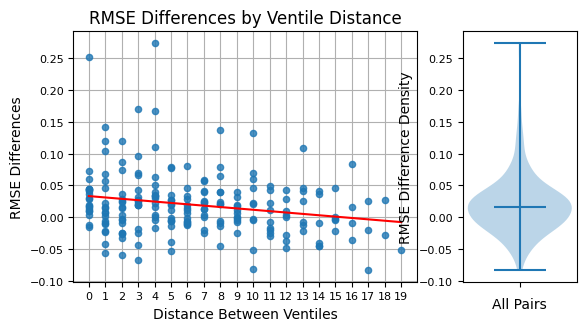

<Figure size 640x480 with 0 Axes>

In [8]:

num_pairs = len(conjoint_results_dicts.keys())

# Initialize a list to store the differences
rmse_differences = []

# Calculating and storing the differences
for pair_idx in range(num_pairs):
    for task_idx in range(num_tasks):
        disjoint_rmse_list = np.repeat(disjoint_results_dicts[task_idx][pair_idx]['rmse_list'], num_tasks)
        conjoint_rmse_list = conjoint_results_dicts[pair_idx]['rmse_list'][task_idx]
        difference = disjoint_rmse_list - conjoint_rmse_list
        rmse_differences.append(difference)
        
        
all_phenotypes_keys = list(all_phenotypes.keys())  # Getting all the keys from your dictionary

# Using itertools to get all unique combinations of length 2 (pairs)
phenotype_pairs = itertools.combinations_with_replacement(all_phenotypes_keys, 2)

# Initialize a list to store pairs with their corresponding RMSE differences
paired_rmse_differences = []

# Iterate over the phenotype pairs and RMSE differences
for pair, rmse_diff in zip(phenotype_pairs, rmse_differences):
    # Appending the RMSE difference to its corresponding pair
    paired_rmse_differences.append((pair, rmse_diff))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(figure_width, figure_height),
                        gridspec_kw={'width_ratios': col_ratios})

ax1 = axs[0]
ax2 = axs[1]

# Initialize a dictionary to store RMSE differences aggregated by Quantile distance
rmse_diff_by_distance = {}

# Calculate RMSE differences and aggregate by distance
for pair, rmse_diff in paired_rmse_differences:
    q1, q2 = [int(q.split()[-1]) for q in pair]
    distance = abs(q1 - q2)
    if distance not in rmse_diff_by_distance:
        rmse_diff_by_distance[distance] = []
    rmse_diff_by_distance[distance].append(np.mean(rmse_diff))

# Prepare data for the scatter plot
x_scatter = []
y_scatter = []
for distance, diffs in rmse_diff_by_distance.items():
    x_scatter.extend([distance] * len(diffs))
    y_scatter.extend(diffs)

# Fitting a linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x_scatter, y_scatter)

# Prepare data for the summary violin plot
all_rmse_diffs = [np.mean(diff) for _, diff in paired_rmse_differences]

# Panel 1: Scatter Plots by Distance with Line of Best Fit
ax1.scatter(x_scatter, y_scatter, alpha=0.8, s=scatter_size, zorder=10)  # alpha for transparency
ax1.plot(x_scatter, slope * np.array(x_scatter) + intercept, color='red', zorder=11)  # Plotting the linear regression line
ax1.set_title(left_title, fontsize=title_font_size)
ax1.set_xlabel(left_x_label, fontsize=label_font_size)
ax1.set_ylabel(left_y_label, fontsize=label_font_size)
ax1.set_xticks(np.arange(0, max(x_scatter) + 1))
ax1.tick_params(axis='both', labelsize=tick_font_size)
ax1.grid(True)

# Panel 2: Summary Violin Plot for All Pairs
ax2.violinplot(all_rmse_diffs, showmeans=False, showmedians=True)
# ax2.set_title(right_title, fontsize=title_font_size)
ax2.set_xlabel(right_x_label, fontsize=label_font_size)
# put a single tick in the middle
ax2.set_xticks([1])
ax2.set_xticklabels([''])

ax2.set_ylabel(right_y_label, fontsize=label_font_size)
ax2.tick_params(axis='both', labelsize=tick_font_size)
# ax2.grid(axis='y')

# Print p-value and r-value
print(f"p-value: {p_value}")
print(f"Correlation coefficient (r): {r_value}")
print(f" slope: {slope}")
print(f" intercept: {intercept}")

# Calculate the number of samples
n = len(x_scatter)

# Degrees of freedom: n - 2 for linear regression
df = n - 2

# Calculate the t-statistic for the slope (slope/std_err)
t_statistic = slope / std_err

# Calculate the confidence interval for the slope
# The standard way to calculate a 95% CI is to use the t-distribution with df and the standard error of the estimate
alpha = 0.05  # for 95% CI
t_critical = stats.t.ppf(1 - alpha/2, df)  # two-tailed inverse of CDF
margin_of_error = t_critical * std_err
lower_bound = slope - margin_of_error
upper_bound = slope + margin_of_error

# Print summary including p-value, r-value, t-statistic, CI for the slope, df, and n
print(f"Linear regression summary (n={n}, df={df}): p-value={p_value:.4f}, r={r_value:.3f}, intercept={intercept:.4f}, slope={slope:.4f}, CI for slope=({lower_bound:.4f}, {upper_bound:.4f}), t-statistic={t_statistic:.3f}")

# plt.tight_layout()

if save_plots_mode:
    plt.savefig(f"{save_dir}{filename}", dpi=dpi_val)
    plt.savefig(f"{save_dir}{filename}.pdf", dpi=dpi_val)
if scrn_mode:
    plt.show()
plt.clf()